# Fig. 5a

In [1]:
import pandas as pd
import PyComplexHeatmap as pch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
lfc_cutoff = 1
padj_cutoff = 0.01

## Read in muscle DEG results

In [3]:
tissue = 'Gastrocnemius'

df_genes = pd.read_csv(f'/share/crsp/lab/seyedam/share/igvf_pipeline/figures/degs_old_pbulk_strategy/{tissue}/results_de_analysis_celltypes_no_min_cells.csv')
ct_degs = df_genes[(df_genes['log2FoldChange'] >= lfc_cutoff) & (df_genes['padj'] <= padj_cutoff)]
ct_degs = ct_degs[['gene_name','subtype', 'tissue']].drop_duplicates()

geno_degs_unfilt = pd.read_csv('/share/crsp/lab/seyedam/share/igvf_pipeline/figures/specificity/sig_degs_all_tissues_b6j.csv', index_col = 0)
geno_degs = geno_degs_unfilt[geno_degs_unfilt['tissue'] == tissue]
geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
mask = geno_degs['comparison'].str.contains('B6J_vs_')
geno_degs.loc[mask, 'log2FoldChange'] = -geno_degs.loc[mask, 'log2FoldChange']
geno_degs['direction'] = np.where(
geno_degs['log2FoldChange'] > 0,
    "Upregulated", 
    "Downregulated")


geno_degs = geno_degs[['gene_name', 'subtype', 'genotype', 'tissue','direction']].drop_duplicates()
merged_df  = pd.merge(geno_degs, ct_degs, on=['gene_name', 'subtype', 'tissue'])


/tmp/ipykernel_3293199/467429875.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs.rename(columns={'celltype': 'subtype'}, inplace=True)
/tmp/ipykernel_3293199/467429875.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geno_degs['direction'] = np.where(


In [4]:
# Group by genotype and subtype and count unique gene_names
gene_counts = merged_df.groupby(['genotype', 'subtype'])['gene_name'].nunique().unstack(fill_value=0)
gene_counts=gene_counts.transpose()
gene_counts['B6J'] = 0

In [5]:
df_row = merged_df[['tissue', 'subtype']].drop_duplicates()


In [6]:
sizes = pd.read_csv(f'/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/obs_tables/{tissue}_annotated_metadata.csv')
cell_counts = sizes.groupby(['subtype', 'Tissue']).size().reset_index(name='num_cells')
total_cells_per_tissue = cell_counts.groupby('Tissue')['num_cells'].sum().reset_index(name='total_cells')
cell_counts = cell_counts.merge(total_cells_per_tissue, on='Tissue')
cell_counts['percent_cells'] = (cell_counts['num_cells'] / cell_counts['total_cells']) * 100


/tmp/ipykernel_3293199/3317122258.py:1: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  sizes = pd.read_csv(f'/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/obs_tables/{tissue}_annotated_metadata.csv')


In [7]:
df_row = df_row.merge(cell_counts, on=['subtype'], how='left')
df_row = df_row.sort_values(by=['percent_cells'], ascending=False)
df_row.index = df_row['subtype']

In [8]:
geno_dict = {
    '129S1J': '#DA9CC1',  
    'AJ': '#F4C245',             
    'B6J': '#C0BFBF',               
    'CASTJ': '#55AF5B',  
    'NODJ': '#4F6EAF',        
    'NZOJ': '#52A5DB',              
    'PWKJ': '#D83026',        
    'WSBJ': '#683C91'   
}

strain_dict = {'Lab': 'darkgrey', 'Wild': '#d3a021'}


df_col = pd.DataFrame({
    "Genotype": gene_counts.columns,
    "Strain type": ["Wild" if x in ["CASTJ","PWKJ","WSBJ"] else "Lab" for x in gene_counts.columns]
})
df_col = df_col.drop_duplicates()

genotype_categories = ['AJ','B6J','129S1J','NODJ','NZOJ','CASTJ','PWKJ','WSBJ']
df_col['Genotype'] = pd.Categorical(df_col['Genotype'], categories=genotype_categories, ordered=True)
df_col.sort_values(['Genotype'], inplace=True)
df_col = df_col.set_index("Genotype", drop=False)

col_ha = pch.HeatmapAnnotation(Genotype=pch.anno_simple(df_col['Genotype'],colors=geno_dict),
                               Type=pch.anno_simple(df_col['Strain type'],colors=strain_dict),
                               verbose=1,
                               label_kws = {'visible': False},
                               axis=1)

## Plot

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 20.844444444444445 mm


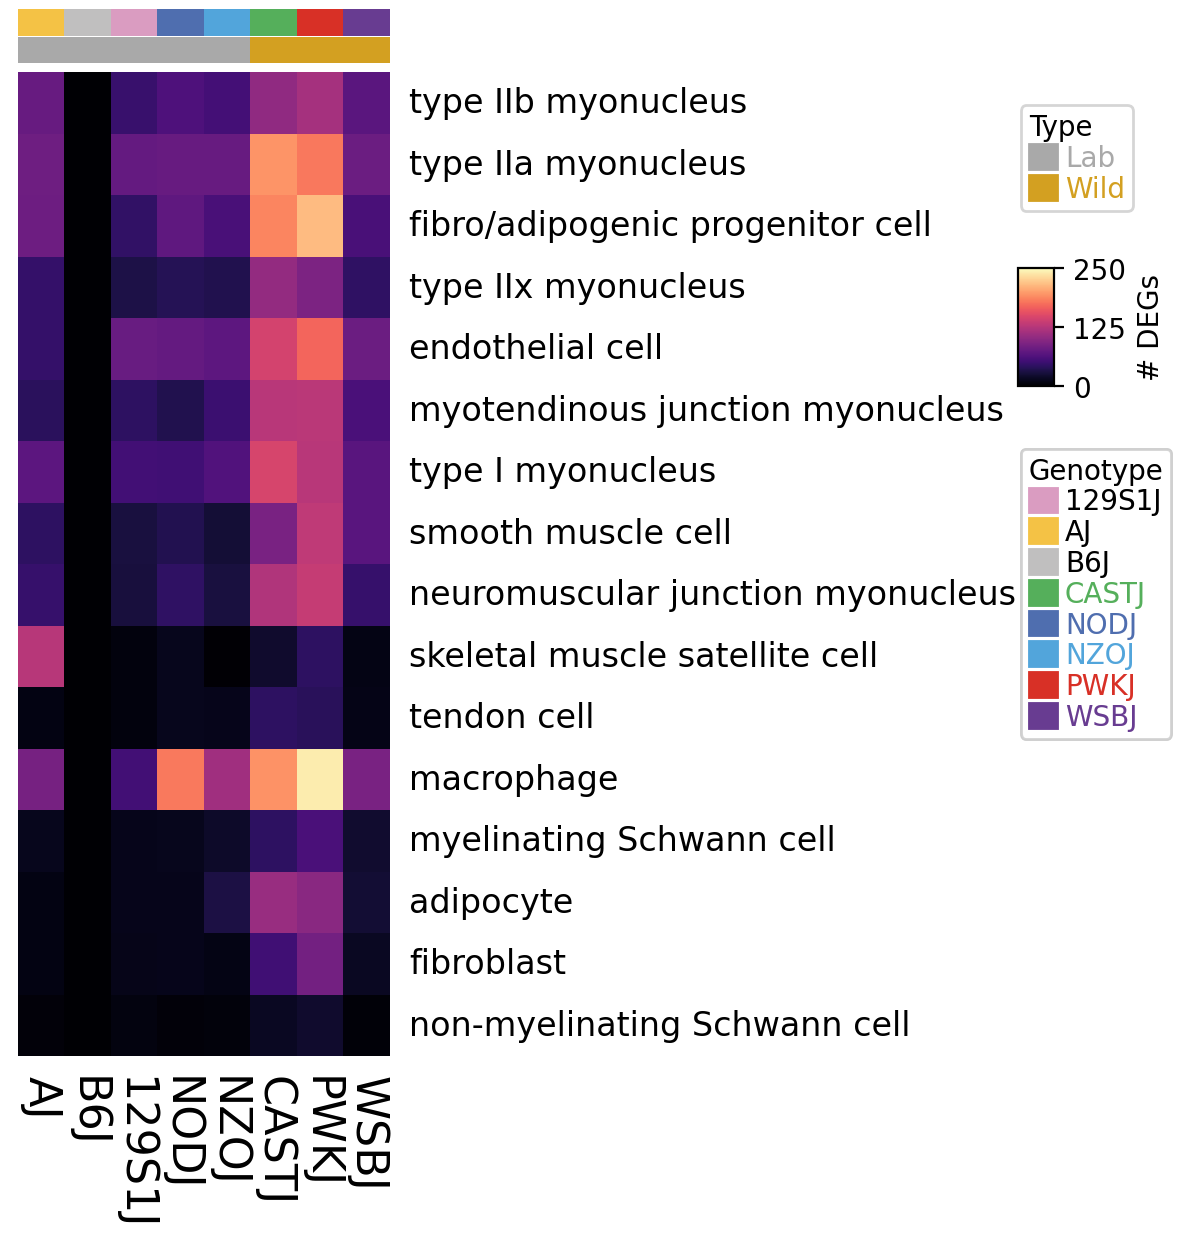

In [9]:
plt.figure(figsize=(2.5, 6), dpi = 200)

pch.ClusterMapPlotter(data=gene_counts.loc[df_row['subtype'].unique().tolist(),df_col.index.tolist()],
                       show_rownames = True, 
                       show_colnames = True, 
                       cmap = "magma",
                       label = "# DEGs",
                       top_annotation=col_ha, 
                       row_cluster=False,
                       col_cluster=False,
                       vmin = 0,
                       vmax = 250,
                       yticklabels_kws={'labelsize': 12},
                       xticklabels_kws={'labelsize': 16} 
                      )

plt.savefig('../fig5/gastroc_deg_hmap.png', dpi=300, bbox_inches='tight')


plt.show()


# Fig. 5b

In [10]:
import gseapy as gp
import numpy as np
import matplotlib.pyplot as plt
import textwrap



In [11]:
merged_df  = geno_degs

In [12]:
celltype = 'skeletal muscle satellite cell'
deg_df = merged_df[merged_df['subtype'] == celltype]
deg_df = deg_df[deg_df['genotype'] == 'AJ']

In [13]:
up = deg_df[deg_df['direction'] == 'Upregulated']
down = deg_df[deg_df['direction'] == 'Downregulated']

In [14]:
enr = gp.enrichr(
    gene_list=up['gene_name'].tolist(),
    organism='Mouse', 
    gene_sets=['Reactome_2022', 'GO_Biological_Process_2023']
)
df = enr.results
df = df.sort_values(by="Adjusted P-value", ascending=True)

df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])
df = df[df['Adjusted P-value'] <= 0.05]
df = df.head(4)

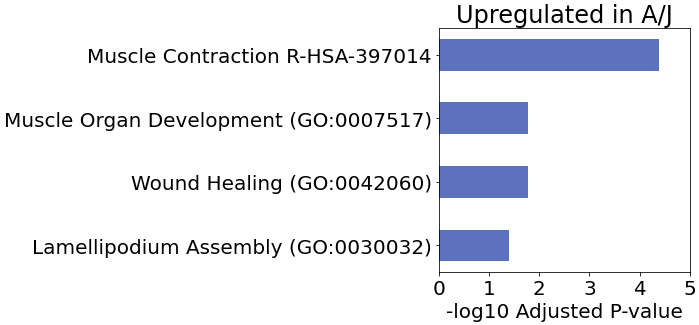

In [15]:
# Plot
plt.figure(figsize=(4.5, 4.5))
plt.barh(df['Term'], df['-log10(Adjusted P-value)'], color='#5C72BF', height = 0.5)
plt.xlabel('-log10 Adjusted P-value', fontsize=20)
plt.ylabel('')
plt.title('Upregulated in A/J', fontsize = 24)
plt.gca().invert_yaxis() 

plt.xticks(np.arange(0, df['-log10(Adjusted P-value)'].max() + 1, 1))
plt.yticks(fontsize=20) 
plt.xticks(fontsize=20)

plt.show()

In [16]:
enr = gp.enrichr(
    gene_list=down['gene_name'].tolist(),
    organism='Mouse', 
    gene_sets=['Reactome_2022', 'GO_Biological_Process_2023']
)
df = enr.results
df = df.sort_values(by="Adjusted P-value", ascending=True)

df['-log10(Adjusted P-value)'] = -np.log10(df['Adjusted P-value'])
df = df[df['Adjusted P-value'] <= 0.05]
df = df.head(4)

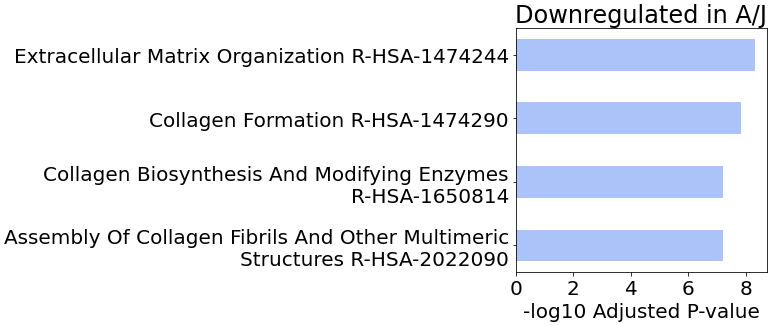

In [17]:
wrapped_labels = [textwrap.fill(label, width=50) for label in df['Term']]

plt.figure(figsize=(4.5, 4.5))
plt.barh(df['Term'], df['-log10(Adjusted P-value)'], color='#ACC3FA', height=0.5)
plt.xlabel('-log10 Adjusted P-value', fontsize=20)
plt.ylabel('')
plt.title('Downregulated in A/J', fontsize=24)
plt.gca().invert_yaxis() 

plt.yticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, fontsize=20)
plt.xticks(fontsize=20)

plt.show()


# Fig. 5c

In [18]:
import Topyfic
import pandas as pd
import scanpy as sc
import numpy as np
import anndata
import random
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.cluster.hierarchy as sch
import PyComplexHeatmap as pch
import seaborn as sns
import decoupler as dc

In [19]:
k = 10
tissue = "Satellite"

## Read in gastroc adata, subset for satellite cells, normalize

Subset for regulatory genes, and also save a version with all genes...

Standalone script for regulatory subset + normalization at `../scripts/topyfic/format_adata_for_topyfic.py`

In [20]:
# adata = sc.read_h5ad('/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/annotated/Gastrocnemius_annotated.h5ad')
# adata = adata[adata.obs['subtype'] == 'skeletal muscle satellite cell'].copy()
# adata.write_h5ad('/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/annotated/Satellite.h5ad')


In [21]:
# def normalization(mtx):
#     pf = mtx.sum(axis=1).A.ravel()
#     log1p_pf = np.log1p(sp.sparse.diags(pf.mean()/pf) @ mtx)
    
#     pf = log1p_pf.sum(axis=1).A.ravel()
#     pf_log1p_pf = sp.sparse.diags(pf.mean()/pf) @ log1p_pf
    
#     return pf_log1p_pf

In [22]:
# path = '/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/annotated/Satellite.h5ad'


In [23]:
# # read in annotated adata
# adata = sc.read_h5ad(path)
# tissue = 'Satellite'

# # subset for regulatory genes
# adata_var = adata.var
# reg_genes = pd.read_csv("/share/crsp/lab/seyedam/share/igvf_pipeline/topyfic/gene_display_table_7categories.csv", index_col = 0)
# reg_genes['regulatory_genes'] = True
# reg_genes = reg_genes[["regulatory_genes", "biotype", "gene_name"]]

# adata_var = adata_var.reset_index(drop=True)
# merged_df = pd.merge(adata_var, reg_genes, how='left', left_on='gene_name', right_on='gene_name')
# merged_df['regulatory_genes'].fillna(False, inplace=True)
# merged_df.index = adata.var.index

# adata.var['regulatory_genes'] = merged_df['regulatory_genes']   
# adatas = adata[:, adata.var["regulatory_genes"]]

# # normalize
# X = adatas.layers['cellbender_counts'] # CELLBENDER COUNTS!
# data = anndata.AnnData(X=X, obs=adatas.obs, var=adatas.var)    
# data.var.set_index('gene_name', inplace=True)
# data.X = normalization(data.X)
# data.X = round(data.X)

# data.write_h5ad(f'/share/crsp/lab/seyedam/share/igvf_pipeline/topyfic/{tissue}_regulatory_only_normalized.h5ad')

In [24]:
reg_genes = pd.read_csv("/share/crsp/lab/seyedam/share/igvf_pipeline/topyfic/gene_display_table_7categories.csv", index_col=0)
data = sc.read_h5ad(f'/share/crsp/lab/seyedam/share/igvf_pipeline/topyfic/{tissue}_regulatory_only_normalized.h5ad')
reg_genes = reg_genes[reg_genes['gene_name'].isin(data.var_names.tolist())]

In [25]:
sns.set_style("white")


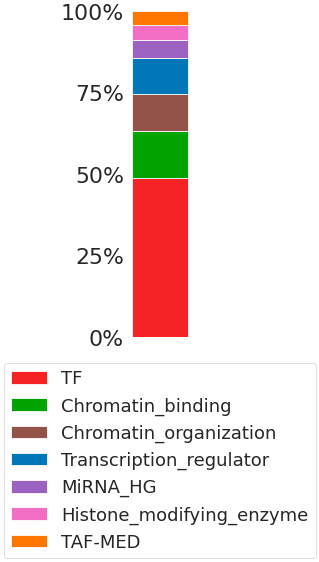

In [26]:
biotype_counts = reg_genes['biotype'].value_counts()
biotype_proportions = biotype_counts / biotype_counts.sum()

biotype_palette = {
    'TF': '#f62324',
    'Chromatin_binding': '#00a300',
    'Chromatin_organization': '#935348',
    'Transcription_regulator': '#0078b8',
    'MiRNA_HG': '#9b62c1',
    'Histone_modifying_enzyme': '#f26ec4',
    'TAF-MED': '#ff7700'
}

biotype_proportions_df = pd.DataFrame(biotype_proportions).T
biotype_proportions_df = biotype_proportions_df[biotype_palette.keys()]

fig, ax = plt.subplots(figsize=(2, 6))
biotype_proportions_df.plot(kind='bar', stacked=True, color=[biotype_palette.get(x, '#808080') for x in biotype_proportions_df.columns], ax=ax)

ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')

ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.get_yaxis().set_tick_params(labelsize=22, pad=-20)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x * 100)}%'))
ax.yaxis.set_tick_params(which='both', length=0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.legend(bbox_to_anchor=(0.5, -0.05), loc='upper center', fontsize=18, ncol=1)
plt.tight_layout()

plt.savefig('../fig5/gene_biotype_barplot.png', dpi=300, bbox_inches='tight')

plt.show()


In [27]:
# # read in annotated adata
# adata = sc.read_h5ad(path)
# tissue = 'Satellite'

# # normalize
# X = adata.layers['cellbender_counts'] # CELLBENDER COUNTS!
# data = anndata.AnnData(X=X, obs=adata.obs, var=adata.var)    
# data.var.set_index('gene_name', inplace=True)
# data.X = normalization(data.X)
# data.X = round(data.X)

# data.write_h5ad(f'/share/crsp/lab/seyedam/share/igvf_pipeline/topyfic/{tissue}_all_genes_normalized.h5ad')


## Run topyfic for k = 10

Run `../scripts/topyfic/run_pbulk_pydeseq2.sh` on HPC for satellite cells subset by regulatory genes, which calls `../scripts/topyfic/topyfic_train.py`.


This generates 100 "train" pickle objects for each LDA run. 

Next, run topyfic_analysis.py:

```
python3 topyfic_analysis.py \
--data /share/crsp/lab/seyedam/share/igvf_pipeline/topyfic/Satellite_regulatory_only_normalized.h5ad \
--tissue Satellite \
-k 10
```

This generates TopModel and analysis pickle objects. hpc3sc env

In [28]:
k = 10
tissue = "Satellite"

Reading TopModel done!


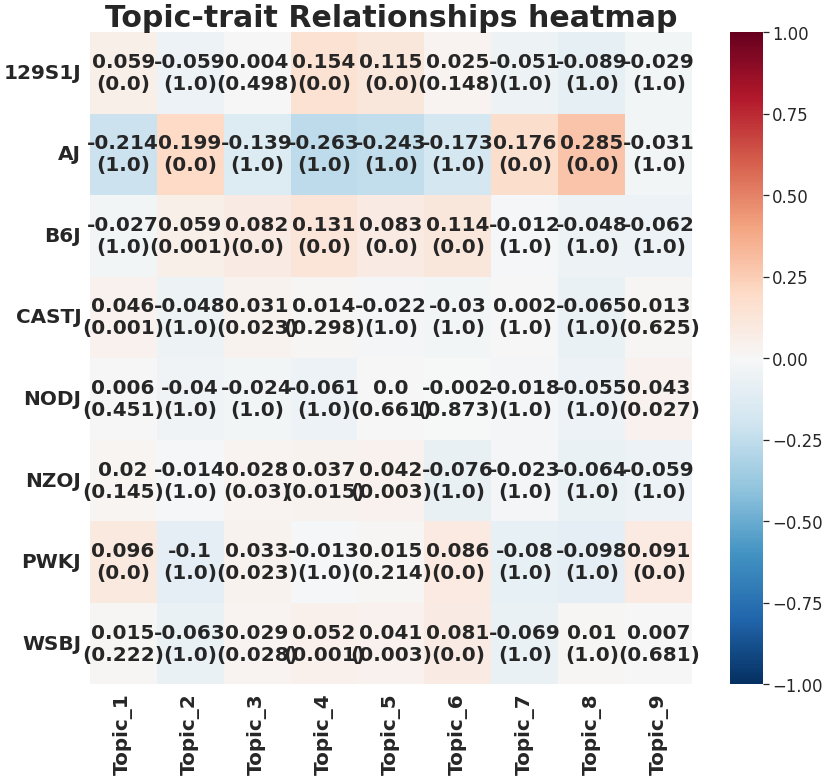

In [29]:
analysis_top_model =  Topyfic.read_topModel(f"../scripts/topyfic/{tissue}/analysis_{tissue}_{k}.p")

metadata = ['Genotype'] 

analysis_top_model.TopicTraitRelationshipHeatmap(metaData=metadata, 
                                                 save=True,
                                                 file_format='pdf', 
                                                 file_name=f'../fig5/{tissue}_{k}_topic-traitRelationships'
                                                )
    

In [30]:
adata = sc.read_h5ad(f'/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/annotated/{tissue}.h5ad')

In [31]:
analysis_tissue = Topyfic.read_topModel(f"../scripts/topyfic/Satellite/analysis_{tissue}_{k}.p")
df = analysis_tissue.cell_participation.to_df()


Reading TopModel done!


In [32]:
# Assuming df is your data matrix (rows = observations, columns = features)
data = df.values  # Convert to NumPy array if not already

# Perform hierarchical clustering
linkage = sch.linkage(data, method='average', metric='correlation')  # or 'average', 'complete', etc.
dendrogram = sch.dendrogram(linkage, no_plot=True)


In [33]:
cluster_ids = sch.fcluster(linkage, t=4, criterion='maxclust')  # Create 4 clusters

print(adata.obs.index.equals(df.index))

adata.obs['subcluster'] = cluster_ids
adata.obs['subcluster'] = "satellite cell subcluster " + adata.obs['subcluster'].astype(str)

swap_mapping = {
    'satellite cell subcluster 1': 'temporary 1',  # Use temporary labels to avoid overwriting
    'satellite cell subcluster 2': 'temporary 2',
    'satellite cell subcluster 3': 'satellite cell subcluster 1',
    'satellite cell subcluster 4': 'satellite cell subcluster 2',
    'temporary 1': 'satellite cell subcluster 3',
    'temporary 2': 'satellite cell subcluster 4'
}

adata.obs['subcluster'] = adata.obs['subcluster'].replace(swap_mapping)

swap_mapping = {
    'temporary 1': 'satellite cell subcluster 3',
    'temporary 2': 'satellite cell subcluster 4'
}

adata.obs['subcluster'] = adata.obs['subcluster'].replace(swap_mapping)


row_df = pd.DataFrame({
    'cellID': adata.obs.index,       # Assuming the index of df contains cell IDs
    'subcluster': adata.obs['subcluster'],
    'Genotype': adata.obs['Genotype']
})

col_df = pd.DataFrame(df.columns, columns=['Topic'])
col_df = col_df.set_index('Topic', drop=False)


True


In [34]:
geno_dict = {
    '129S1J': '#DA9CC1',  
    'AJ': '#F4C245',             
    'B6J': '#C0BFBF',               
    'CASTJ': '#55AF5B',  
    'NODJ': '#4F6EAF',        
    'NZOJ': '#52A5DB',              
    'PWKJ': '#D83026',        
    'WSBJ': '#683C91'   
}


topic_dict = {
    'Topic_1': '#D02F05',  
    'Topic_2': '#EECF3A',             
    'Topic_3': '#4043A7',               
    'Topic_4': '#28d3cc',  
    'Topic_5': '#A4FC3C',        
    'Topic_6': '#28BCEB',              
    'Topic_7': '#007FFF',        
    'Topic_8': '#F05C13',
    'Topic_9': '#520b8c'   
}

group_dict = {
    'satellite cell subcluster 1': '#EF6A6E', 
    'satellite cell subcluster 2': 'skyblue', 
    'satellite cell subcluster 3': '#85C88A', 
    'satellite cell subcluster 4': '#F7D76A',  
}


In [35]:
col_ha = pch.HeatmapAnnotation(Topic=pch.anno_simple(col_df['Topic'],colors=topic_dict),
                               label_kws = {'visible': False},
                               plot_legend=False,
                               verbose=1,axis=1)

left_ha = pch.HeatmapAnnotation(Genotype=pch.anno_simple(row_df['Genotype'],colors=geno_dict),
                                subcluster=pch.anno_simple(row_df['subcluster'],colors=group_dict),
                                label_kws = {'visible': False},
                                plot_legend=False,
                                axis=0)


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.0 mm


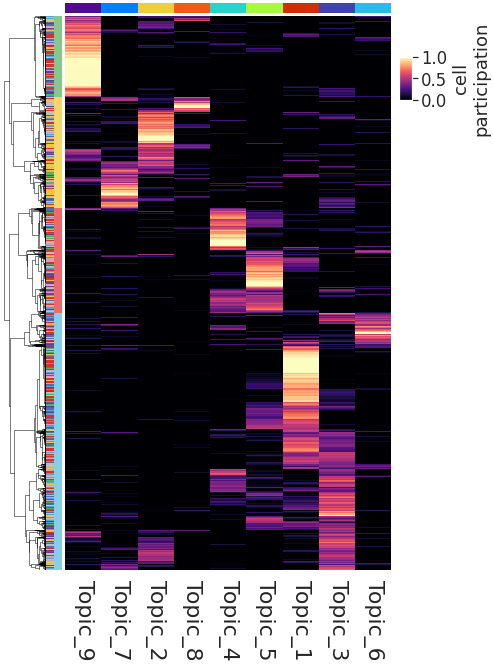

In [36]:
plt.figure(figsize=(7, 9))
cm = pch.ClusterMapPlotter(data=df,
                           show_rownames = False, 
                           show_colnames = True, 
                           cmap = "magma",
                           label = "cell\nparticipation",
                           legend_vpad = 15,
                           row_dendrogram_size=15,
                           top_annotation=col_ha, 
                           left_annotation=left_ha,
                           row_cluster=True,
                           row_dendrogram=True,
                           col_cluster=True,
                           xticklabels_kws={'labelsize': 22}
                          )

plt.savefig('../fig5/cell_participation_clusters.png', dpi=300, bbox_inches='tight')

plt.show()


# Fig. 5d

In [37]:
analysis_tissue = Topyfic.read_topModel(f"../scripts/topyfic/Satellite/analysis_{tissue}_{k}.p")


Reading TopModel done!


In [38]:
analysis_tissue.cell_participation.obs['subcluster'] = adata.obs['subcluster']


In [39]:
analysis_tissue.colors_topics.colors["Topic_1"] = "#D02F05"
analysis_tissue.colors_topics.colors["Topic_2"] = "#EECF3A"

analysis_tissue.colors_topics.colors["Topic_3"] = "#4043A7"
analysis_tissue.colors_topics.colors["Topic_4"] = "#28d3cc"

analysis_tissue.colors_topics.colors["Topic_5"] = "#A4FC3C"
analysis_tissue.colors_topics.colors["Topic_6"] = "#28BCEB"
analysis_tissue.colors_topics.colors["Topic_7"] = "#007FFF"  # 4043A7 #eecf36
analysis_tissue.colors_topics.colors["Topic_8"] = "#F05C13" 
analysis_tissue.colors_topics.colors["Topic_9"] = "#520b8c"


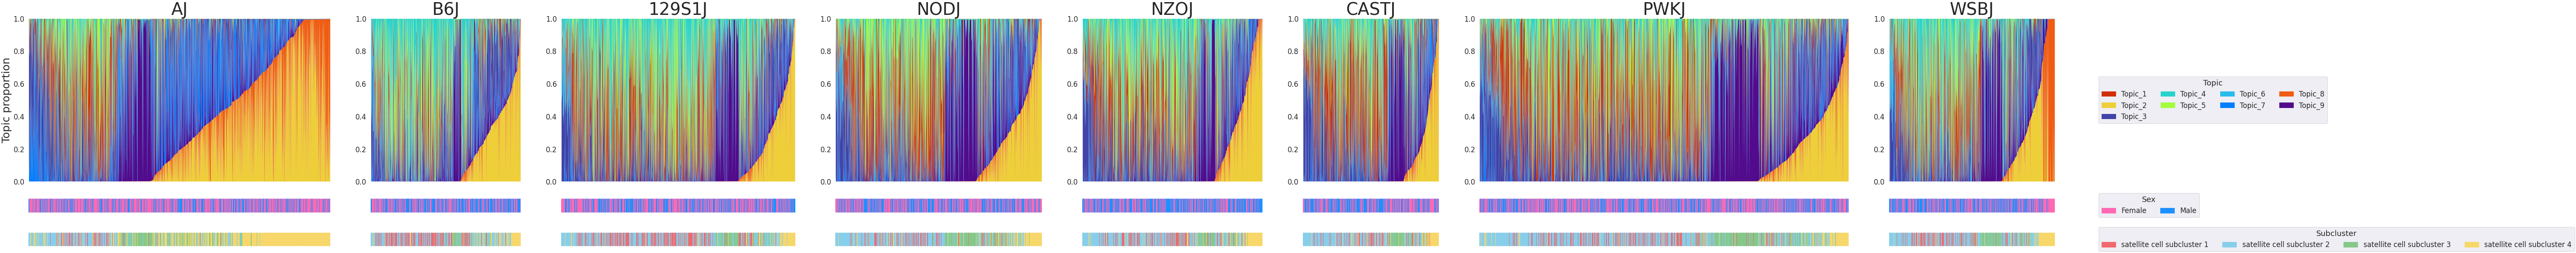

In [40]:
my_palette_geno = {'AJ': '#F4C245','B6J': '#C0BFBF','129S1J': '#DA9CC1','NODJ': '#4F6EAF','NZOJ': '#52A5DB', 'CASTJ': '#55AF5B','PWKJ': '#D83026','WSBJ': '#683C91'}
genos = ['AJ','B6J','129S1J','NODJ','NZOJ','CASTJ','PWKJ', 'WSBJ']

my_palette_sex = {'Female': 'hotpink','Male': 'dodgerblue'}
my_palette_cluster = {'satellite cell subcluster 1': '#EF6A6E',
                      'satellite cell subcluster 2': 'skyblue',
                      'satellite cell subcluster 3': '#85C88A',
                      'satellite cell subcluster 4': '#F7D76A',
                     }


my_palette = {'Sex': my_palette_sex, 'subcluster': my_palette_cluster}





analysis_tissue.structure_plot(level='Genotype',category=genos, 
                                  topic_order =['Topic_2','Topic_8','Topic_9',
                                                'Topic_7','Topic_3',
                                                'Topic_6','Topic_1','Topic_5','Topic_4',], 
                                  metaData=['Sex', 'subcluster'],
                                  metaData_palette=my_palette, 
                                  order_cells=["sum"],
                                  save=True,file_format='png', file_name='../fig5/structure_plot_k10_subclustered',
                                  show=True)



In [41]:
cell_meta = adata.obs
cell_meta.reset_index(inplace=True)
cell_meta = cell_meta[['cellID','Genotype','Sex']]

analysis_tissue = Topyfic.read_topModel(f"../scripts/topyfic/Satellite/analysis_{tissue}_{k}.p")
df = analysis_tissue.cell_participation.to_df()
df = df.reset_index()
merged_df = pd.merge(df, cell_meta, on='cellID')

merged_df['Genotype'] = merged_df['Genotype'].astype(str)
df_percentage = merged_df.groupby('Genotype')[['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9']].sum()
df_percentage = df_percentage.div(df_percentage.sum(axis=1), axis=0) * 100  # Multiplying by 100 to get percentages
df_pivot=df_percentage


Reading TopModel done!


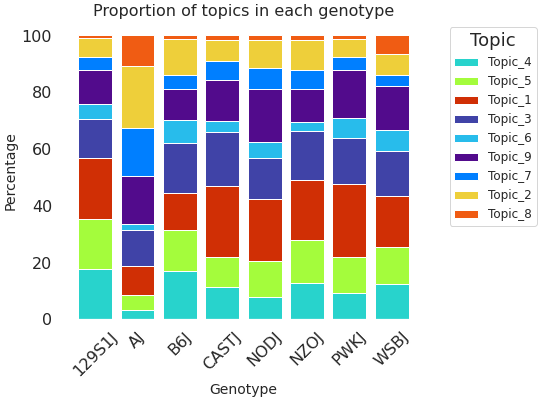

In [42]:
plt.figure(figsize=(8, 6))
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

bottom = None
for topic in ['Topic_4','Topic_5','Topic_1',
              'Topic_3','Topic_6','Topic_9',
              'Topic_7','Topic_2','Topic_8',
             ]:
    plt.bar(df_pivot.index, df_pivot[topic], color=topic_dict[topic], label=topic, bottom=bottom)
    if bottom is None:
        bottom = df_pivot[topic]
    else:
        bottom += df_pivot[topic]

# Add labels and title with specified font sizes
plt.xlabel('Genotype', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Proportion of topics in each genotype', fontsize=16)
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.savefig('../fig5/satellite_k10_topic_summary_barplot.pdf')


plt.show()


# Fig. 5e

In [43]:
def stacked_barplot_proportions(adata, cluster_key, var_key, fsize=(12, 6), annotations=True, reverse_order=False, custom_order=None, custom_colors=None, save_path = None):
    colors = sns.color_palette("husl", n_colors=len(adata[var_key].unique()))

    # Group the data by 'cluster_key' and 'var_key', count occurrences, and calculate proportions
    grouped_data = adata.groupby([cluster_key, var_key]).size().unstack().fillna(0)
    proportions = grouped_data.div(grouped_data.sum(axis=1), axis=0)

    # Apply custom order if provided
    if custom_order:
        proportions = proportions.loc[custom_order]
        
        # Recalculate 'm' with Genotype counts based on custom_order
        m = adata.groupby(['Genotype']).size().to_frame()
        m = m.reset_index()
        m['Genotype'] = pd.Categorical(m['Genotype'], categories=custom_order, ordered=True)
        m = m.sort_values('Genotype').reset_index(drop=True)
        m = m.set_index('Genotype')
        #print(m)

    if custom_colors:
        colors = custom_colors


        
        
    # Reverse the order of the DataFrame if reverse_order is True
    if reverse_order:
        proportions = proportions.iloc[::-1]
        m = m.iloc[::-1]

    # Create the stacked bar plot
    ax = proportions.plot(kind='barh', color=colors, stacked=True, figsize=fsize, width=0.8, edgecolor=None)

    # Remove the plot outline (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)
        
    if annotations:
        for i, txt in enumerate(m[0]):
            # Annotate using the sorted m DataFrame
            #print(txt)
            ax.text(0.875, i, f'{txt}', fontsize=15, va='center', transform=ax.get_yaxis_transform())

    plt.xlim(0, 1.15)
    
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=18)
    ax.set_xlabel("Proportion")
    ax.set_ylabel(cluster_key)
    ax.set_title(f'{var_key} by {cluster_key}')
    
    ax.get_legend().remove()

    # ax.grid(False)
    

    if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


In [44]:
sns.set_context("paper", font_scale=2) 
sns.set_style("white")


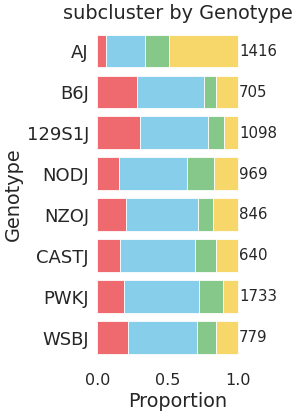

In [45]:
stacked_barplot_proportions(adata.obs, 
                            'Genotype', 'subcluster',
                            reverse_order = True,
                            fsize = (2.9,6.25), 
                            custom_order = [ 'AJ', 'B6J','129S1J', 'NODJ','NZOJ','CASTJ','PWKJ', 'WSBJ'],
                            custom_colors = ['#EF6A6E', 'skyblue','#85C88A', '#F7D76A', ],
                            annotations = True,
                            save_path = '../fig5/satellite_subcluster_barplot.png')


# Fig. 5f

In [46]:
pbdata = dc.get_pseudobulk(adata,
                            sample_col='subcluster',
                            groups_col='Genotype',
                            layer='cellbender_counts',
                            mode='sum',
                            min_cells=10,
                            min_counts=1000)

sc.pp.normalize_total(pbdata, target_sum=1e6)
df = pbdata.to_df().transpose()

In [47]:
genes = ['Myog','Myod1','Myh3','Mef2c','Pax7','Myf5',
         'Myf6','Colq','Musk','Dysf','Lrp4','Myh8','Spry1','Spry4']#,'Top2a','Mki67']


filtered_df = df[df.index.isin(genes)]

filtered_df_scaled = filtered_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)


In [48]:
df_col = pbdata.obs
df_col.index = pbdata.obs.index

group_dict = {
    'satellite cell subcluster 1': '#EF6A6E', 
    'satellite cell subcluster 2': 'skyblue', 
    'satellite cell subcluster 3': '#85C88A', 
    'satellite cell subcluster 4': '#F7D76A',  
}

geno_dict = {
    '129S1J': '#DA9CC1',  
    'AJ': '#F4C245',             
    'B6J': '#C0BFBF',               
    'CASTJ': '#55AF5B',  
    'NODJ': '#4F6EAF',        
    'NZOJ': '#52A5DB',              
    'PWKJ': '#D83026',        
    'WSBJ': '#683C91'   
}


col_ha = pch.HeatmapAnnotation(cluster=pch.anno_simple(df_col['subcluster'],colors=group_dict),
                               Genotype=pch.anno_simple(df_col['Genotype'],colors=geno_dict),
                               plot_legend=False,
                               verbose=1,axis=1, label_kws = {'visible': False})


genotype_categories = [ 'AJ', 'B6J', '129S1J','NODJ','NZOJ','CASTJ','PWKJ',   'WSBJ' ]
group_categories = ['satellite cell subcluster 1', 'satellite cell subcluster 2', 'satellite cell subcluster 3', 'satellite cell subcluster 4']

df_col['Genotype'] = pd.Categorical(df_col['Genotype'], categories=genotype_categories, ordered=True)
df_col['subcluster'] = pd.Categorical(df_col['subcluster'], categories=group_categories, ordered=True)
order_criteria = ['subcluster', 'Genotype']

# Sort df_col using order_criteria
df_col.sort_values(order_criteria, inplace=True)



Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 7.0 mm


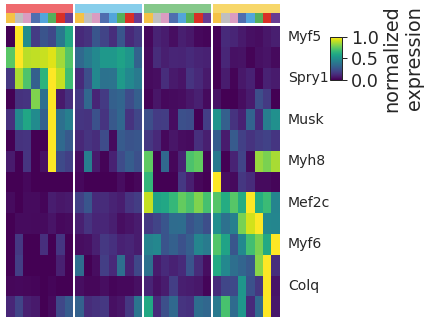

In [49]:
plt.figure(figsize=(5, 5))
cm = pch.ClusterMapPlotter(data=filtered_df_scaled.loc[:,df_col.index.tolist()],
                           show_rownames = True, 
                           col_split_gap = 0.8,
                           cmap = "viridis",
                           label = "normalized\nexpression",
                           top_annotation=col_ha, 
                           row_cluster=True,
                           col_cluster=False,
                           col_split=df_col['subcluster'],
                           col_split_order=group_categories,
                           yticklabels_kws={'labelsize': 14}
                          )

plt.savefig("../fig5/satellite_topic_cluster_selected_genes.png",bbox_inches='tight', dpi = 300)


plt.show()


# Fig. 5g

In [50]:
# import liana as li
# from liana.mt import rank_aggregate
# from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean
# import scanpy as sc

# tissue = 'Gastrocnemius'
# print("Reading adata...", flush = True)
# adata = sc.read_h5ad(f'/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/annotated/{tissue}_annotated_high_quality.h5ad')

# print("Normalizing adata...", flush = True)
# adata.X = adata.layers['cellbender_counts']
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# genos = ['AJ','B6J','CASTJ','PWKJ','WSBJ','NODJ','NZOJ','129S1J']

# for geno in genos:
#     print(f"Processing {geno}...", flush = True)
    
#     adata_filt = adata[adata.obs['Genotype'] == geno]
    
#     li.mt.rank_aggregate(adata_filt,
#                          groupby='subtype_subclustered',
#                          use_raw=False,
#                          resource_name='mouseconsensus',
#                          expr_prop=0.1,
#                          verbose=True)
    
#     print(f"Saving {geno} adata...", flush = True)
#     adata_filt.write_h5ad(f'/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/{tissue}_{geno}_annotated_liana_norm_subclustered.h5ad')




In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [52]:
genos = ['AJ','B6J','129S1J','NODJ','NZOJ','CASTJ','PWKJ','WSBJ']
interaction_counts_all = []
for genotype in genos:
    print(genotype)
    # Load data
    adata = sc.read_h5ad(f'/share/crsp/lab/seyedam/share/igvf_pipeline/IGVF_analysis/cellbender_tissues/Gastrocnemius_{genotype}_annotated_liana_norm_subclustered.h5ad')
    
    # Extract interaction counts
    df = adata.uns['liana_res']
    df = df[df['cellphone_pvals'] <= 0.05]
    df['genotype'] = genotype  # Add genotype column
    df['ligand_receptor'] = df['ligand_complex'].astype(str) + "->" + df['receptor_complex'].astype(str)
    df= df[['genotype', 'source', 'target', 'ligand_receptor']].drop_duplicates()

    interaction_counts_all.append(df)

# Combine all interaction counts into one DataFrame
df = pd.concat(interaction_counts_all)

# Define the mapping for swapping subcluster names
swap_mapping = {
    'satellite cell subcluster 1': 'temporary 1',  # Use temporary labels to avoid overwriting
    'satellite cell subcluster 2': 'temporary 2',
    'satellite cell subcluster 3': 'satellite cell subcluster 1',
    'satellite cell subcluster 4': 'satellite cell subcluster 2',

}

# Apply the mapping to the 'target' column
df['target'] = df['target'].replace(swap_mapping)
df['source'] = df['source'].replace(swap_mapping)

swap_mapping = {
    'temporary 1': 'satellite cell subcluster 3',
    'temporary 2': 'satellite cell subcluster 4'
}

# Apply the mapping to the 'target' column
df['target'] = df['target'].replace(swap_mapping)
df['source'] = df['source'].replace(swap_mapping)


AJ
B6J
129S1J
NODJ
NZOJ
CASTJ
PWKJ
WSBJ


In [53]:
sns.set_context("paper", font_scale=2) # set some nice global plotting settings.


In [54]:
order = ['satellite cell subcluster 3', 'satellite cell subcluster 4', 'macrophage', 
 'neuromuscular junction myonucleus', 'fibro/adipogenic progenitor cell', 'non-myelinating Schwann cell', 
 'satellite cell subcluster 2','tendon cell','endothelial cell', 
 'type IIb myonucleus','type IIx myonucleus','fibroblast',
 'lymphatic endothelial cell', 'myelinating Schwann cell', 'myotendinous junction myonucleus',
 'smooth muscle cell', 'adipocyte', 'type I myonucleus', 'satellite cell subcluster 1','type IIa myonucleus']

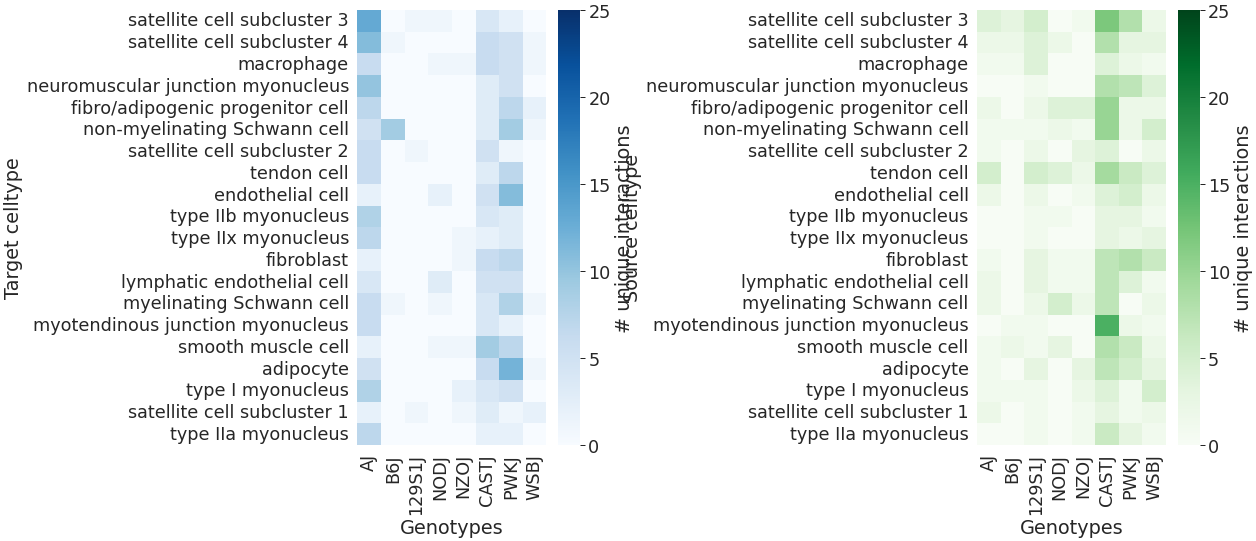

In [55]:
# List of genotypes
genotypes = ['AJ','B6J','129S1J','NODJ','NZOJ','CASTJ','PWKJ','WSBJ']

# Create dictionaries to store genotype-specific interactions for both source and target heatmaps
source_interaction_counts = {genotype: {} for genotype in genotypes}
target_interaction_counts = {genotype: {} for genotype in genotypes}

# Loop through genotypes to calculate genotype-specific interactions
for genotype in genotypes:
    # Filter interactions for the current genotype
    genotype_interactions = df[df['genotype'] == genotype]
    
    # Get all interactions for the current genotype
    genotype_pairs = set(genotype_interactions[['source', 'target', 'ligand_receptor']].apply(tuple, axis=1))

    # Get interactions in other genotypes
    non_genotype_interactions = df[df['genotype'] != genotype]
    non_genotype_pairs = set(non_genotype_interactions[['source', 'target', 'ligand_receptor']].apply(tuple, axis=1))
    
    # Identify genotype-specific interactions (those only in this genotype)
    unique_genotype_pairs = genotype_pairs - non_genotype_pairs
    
    # Filter for interactions where satellite cells are the source (for the source heatmap)
    satellite_cells_source = genotype_interactions[genotype_interactions['source'] == 'satellite cell subcluster 1']
    unique_source_interactions = satellite_cells_source[satellite_cells_source[['source', 'target', 'ligand_receptor']].apply(tuple, axis=1).isin(unique_genotype_pairs)]
    source_counts = unique_source_interactions.groupby('target').size()
    source_interaction_counts[genotype] = source_counts

    # Filter for interactions where satellite cells are the target (for the target heatmap)
    satellite_cells_target = genotype_interactions[genotype_interactions['target'] == 'satellite cell subcluster 1']
    unique_target_interactions = satellite_cells_target[satellite_cells_target[['source', 'target', 'ligand_receptor']].apply(tuple, axis=1).isin(unique_genotype_pairs)]
    target_counts = unique_target_interactions.groupby('source').size()
    target_interaction_counts[genotype] = target_counts


# Combine counts into a matrix (rows = cell types, columns = genotypes)
source_matrix = pd.DataFrame(source_interaction_counts).fillna(0)  # .T transposes for genotypes as columns
target_matrix = pd.DataFrame(target_interaction_counts).fillna(0)

source_matrix_sorted = source_matrix.loc[order]
target_matrix_sorted = target_matrix.loc[source_matrix_sorted.index]

fig, axes = plt.subplots(1, 2, figsize=(17.5, 8))

# Heatmap 1: Satellite Cells as the Source
sns.heatmap(source_matrix_sorted, annot=False, fmt='d',vmax = 25,
            cmap='Blues', 
            ax=axes[0], 
            cbar_kws={'label': '# unique interactions'})
axes[0].set_title("", fontsize=22)
axes[0].set_ylabel("Target celltype")
axes[0].set_xlabel("Genotypes")

# Heatmap 2: Satellite Cells as the Target
sns.heatmap(target_matrix_sorted, annot=False, fmt='d', vmax = 25,
            cmap='Greens', ax=axes[1], 
            cbar_kws={'label': '# unique interactions'})
axes[1].set_title("", fontsize=22)
axes[1].set_ylabel("Source celltype")
axes[1].set_xlabel("Genotypes")

# Adjust layout to make space for both heatmaps
plt.tight_layout()

plt.savefig("../fig5/liana_subcluster_1_hmap.png",bbox_inches='tight', dpi = 300)

plt.show()

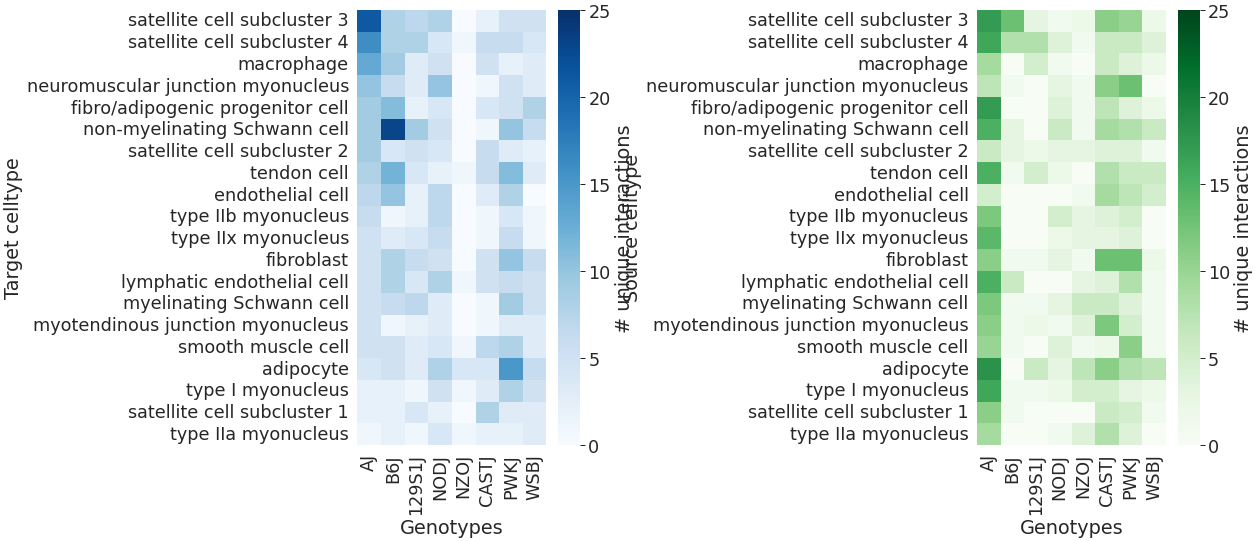

In [56]:
source_interaction_counts = {genotype: {} for genotype in genotypes}
target_interaction_counts = {genotype: {} for genotype in genotypes}

# Loop through genotypes to calculate genotype-specific interactions
for genotype in genotypes:
    # Filter interactions for the current genotype
    genotype_interactions = df[df['genotype'] == genotype]
    
    # Get all interactions for the current genotype
    genotype_pairs = set(genotype_interactions[['source', 'target', 'ligand_receptor']].apply(tuple, axis=1))

    # Get interactions in other genotypes
    non_genotype_interactions = df[df['genotype'] != genotype]
    non_genotype_pairs = set(non_genotype_interactions[['source', 'target', 'ligand_receptor']].apply(tuple, axis=1))
    
    # Identify genotype-specific interactions (those only in this genotype)
    unique_genotype_pairs = genotype_pairs - non_genotype_pairs
    
    # Filter for interactions where satellite cells are the source (for the source heatmap)
    satellite_cells_source = genotype_interactions[genotype_interactions['source'] == 'satellite cell subcluster 4']
    unique_source_interactions = satellite_cells_source[satellite_cells_source[['source', 'target', 'ligand_receptor']].apply(tuple, axis=1).isin(unique_genotype_pairs)]
    source_counts = unique_source_interactions.groupby('target').size()
    source_interaction_counts[genotype] = source_counts

    # Filter for interactions where satellite cells are the target (for the target heatmap)
    satellite_cells_target = genotype_interactions[genotype_interactions['target'] == 'satellite cell subcluster 4']
    unique_target_interactions = satellite_cells_target[satellite_cells_target[['source', 'target', 'ligand_receptor']].apply(tuple, axis=1).isin(unique_genotype_pairs)]
    target_counts = unique_target_interactions.groupby('source').size()
    target_interaction_counts[genotype] = target_counts


source_matrix = pd.DataFrame(source_interaction_counts).fillna(0) 
target_matrix = pd.DataFrame(target_interaction_counts).fillna(0)
source_matrix_sorted = source_matrix.loc[order]
target_matrix_sorted = target_matrix.loc[source_matrix_sorted.index]


fig, axes = plt.subplots(1, 2, figsize=(17.5, 8))

# Heatmap 1: Satellite Cells as the Source
sns.heatmap(source_matrix_sorted, annot=False, fmt='d',vmax = 25, # 42
            cmap='Blues', 
            ax=axes[0], 
            cbar_kws={'label': '# unique interactions'})
axes[0].set_title("", fontsize=22)
axes[0].set_ylabel("Target celltype")
axes[0].set_xlabel("Genotypes")

# Heatmap 2: Satellite Cells as the Target
sns.heatmap(target_matrix_sorted, annot=False, fmt='d', vmax = 25, # 42
            cmap='Greens', ax=axes[1], 
            cbar_kws={'label': '# unique interactions'})
axes[1].set_title("", fontsize=22)
axes[1].set_ylabel("Source celltype")
axes[1].set_xlabel("Genotypes")

plt.tight_layout()

plt.savefig("../fig5/liana_subcluster_4_hmap.png",bbox_inches='tight', dpi = 300)

plt.show()

# Make legends

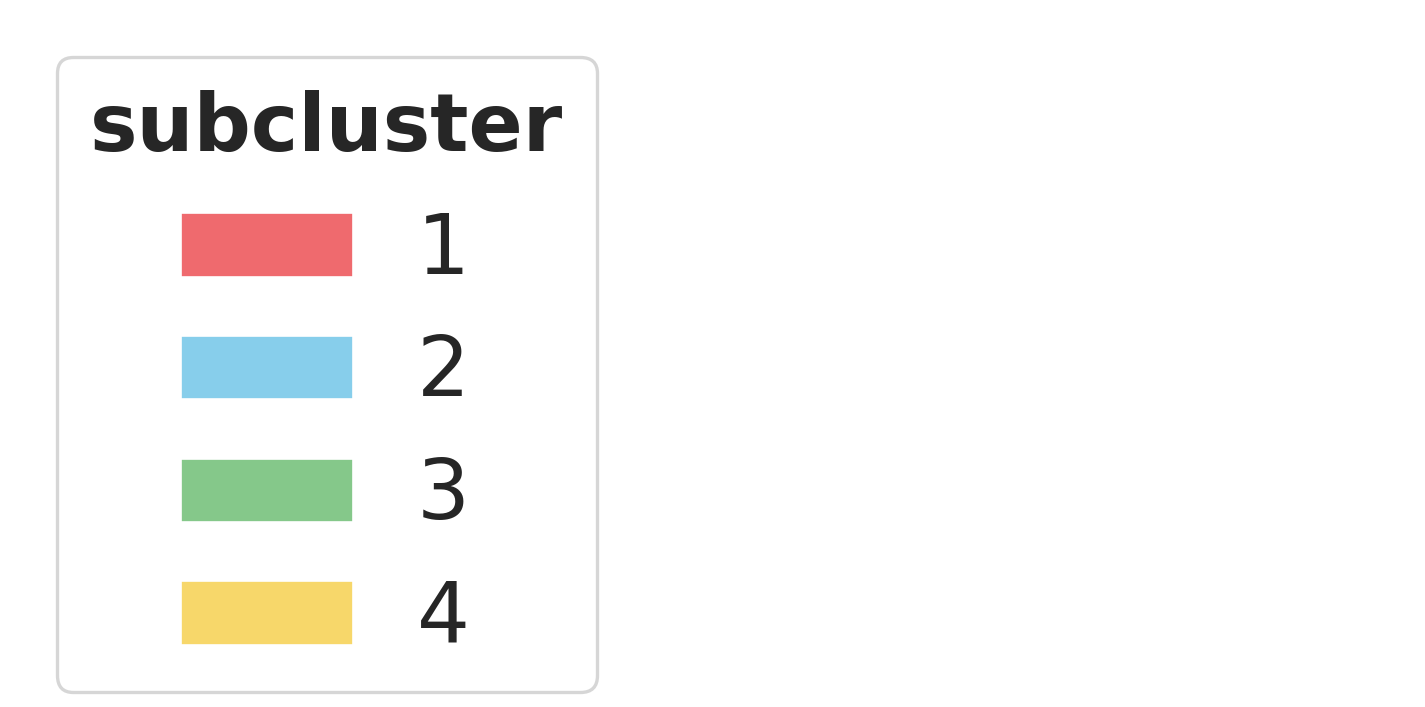

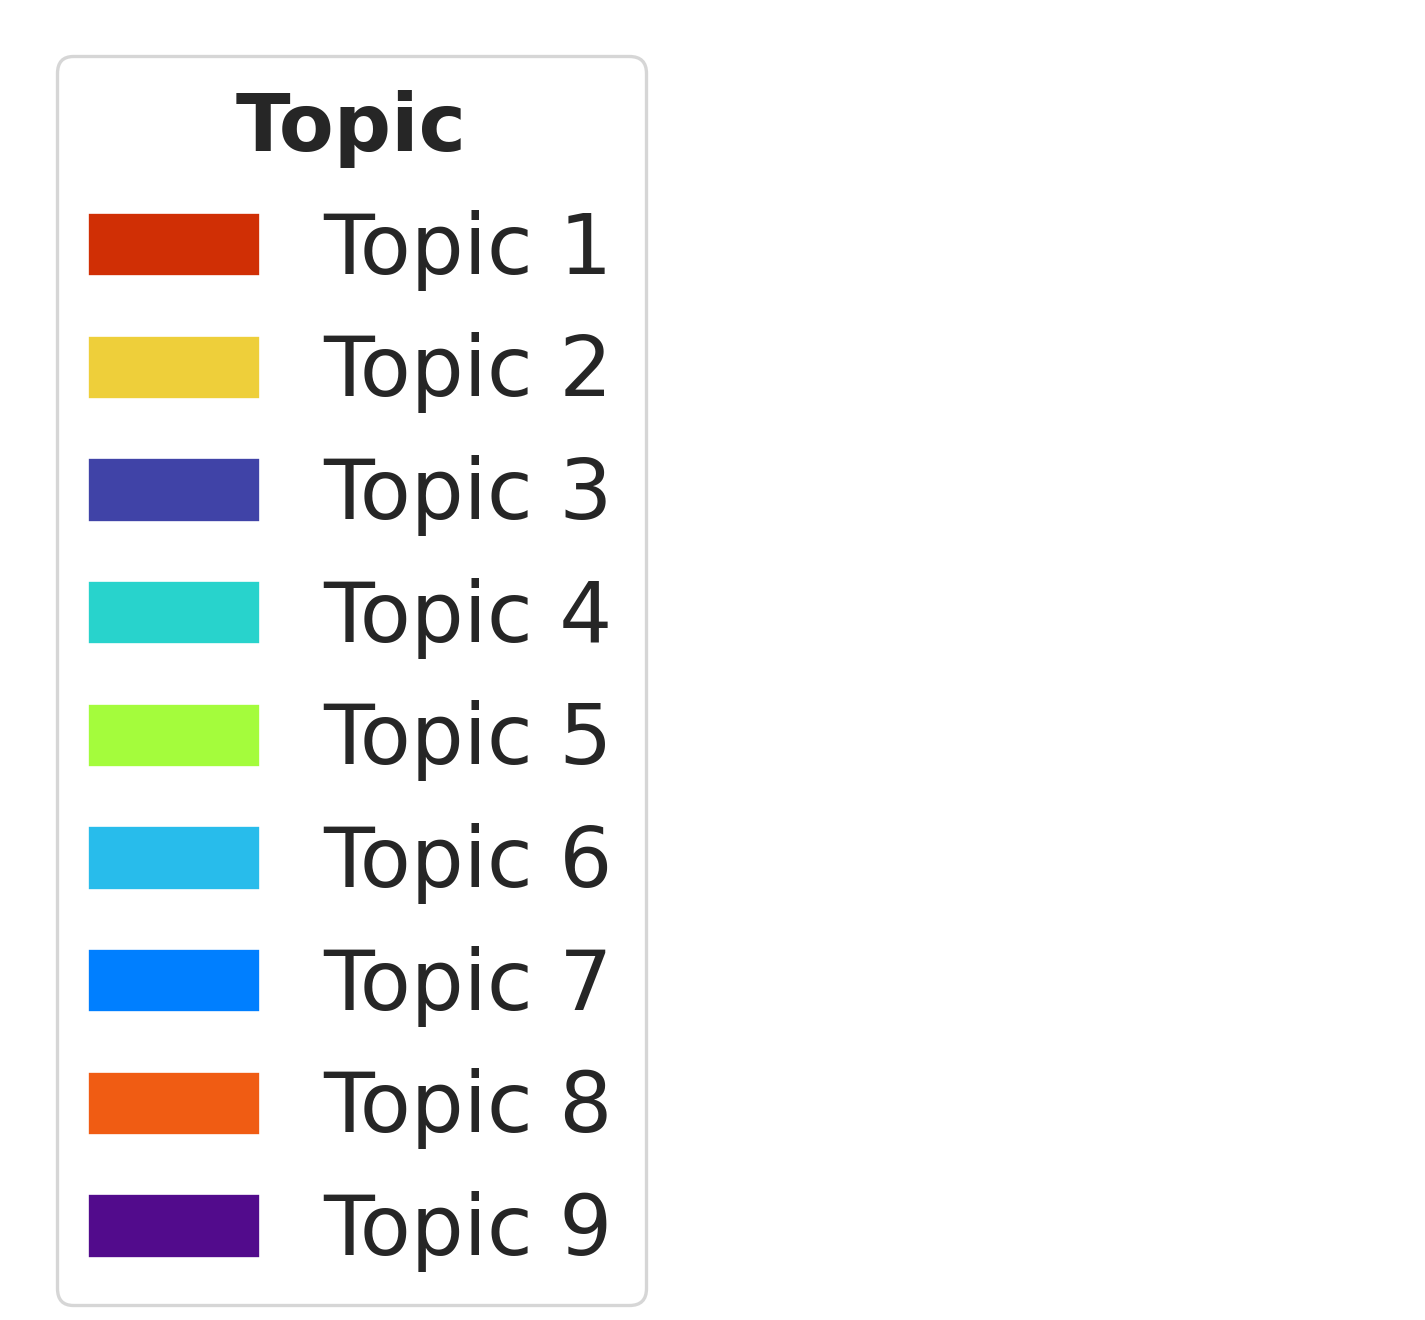

In [57]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def create_standalone_legend(color_dict, label, order, location='upper left'):
    ordered_dict = {key: color_dict[key] for key in order if key in color_dict}
    legend_handles = [mpatches.Patch(color=color) for color in ordered_dict.values()]
    legend_labels = list(ordered_dict.keys())  # Legend items in the correct order

    fig, ax = plt.subplots(figsize=(6, 1))
    legend = ax.legend(legend_handles, legend_labels,
                       title=label, loc=location, fontsize=20, title_fontsize=5)
    legend.set_title(label, prop={'weight': 'bold'})  # Make the legend title bold
    ax.axis('off')  
    fig.set_dpi(300)
    plt.savefig(f"../fig5/{label}_legend.png",bbox_inches='tight', dpi = 300)
    plt.show()
    
group_dict = {
    '1': '#EF6A6E', 
    '2': 'skyblue', 
    '3': '#85C88A', 
    '4': '#F7D76A',  
}
clust_order = ['1',
               '2',
               '3',
               '4']

create_standalone_legend(group_dict, 'subcluster', clust_order, location='upper left')


topic_colors = {
    "Topic 1": "#D02F05",
    "Topic 2": "#EECF3A",
    "Topic 3": "#4043A7",
    "Topic 4": "#28d3cc",
    "Topic 5": "#A4FC3C",
    "Topic 6": "#28BCEB",
    "Topic 7": "#007FFF",
    "Topic 8": "#F05C13",
    "Topic 9": "#520b8c"
}

topic_order = [
    'Topic 1',
    'Topic 2',
    'Topic 3',
    'Topic 4',
    'Topic 5',
    'Topic 6',
    'Topic 7',
    'Topic 8',
    'Topic 9'
]

create_standalone_legend(topic_colors, 'Topic', topic_order, location='upper left')


